# Basic Analysis of Data

In [1]:
from collections import Counter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
from scipy.stats import gaussian_kde
from scipy.interpolate import spline
from scipy.io import loadmat, savemat
import pandas as pd
import pymc as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal as MVN

import re
import numpy as np

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#------------------    Read in and Process Real Data    ----------------------#
# Read 311 data
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

# Filter for closed cases
t1 = time.time()
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
t2 = time.time()
print "Filtered data in %.2f seconds." % (t2 - t1)

# Convert dates to datetime type
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    closed_requests[col] = pd.to_datetime(closed_requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2 - t1)

Read in data in 12.87 seconds.
Filtered data in 0.41 seconds.

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dates processed in 1282.99 seconds.


In [51]:
def real_data(begin_date, end_date, source, landmark_date, reason=None, dept=None, random=None):
    begin = pd.to_datetime(begin_date) 
    end = pd.to_datetime(end_date)
    
    # Filter for requests opened between begin and end dates
    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]
    
    # Filter for requests with specific source
    in_range = in_range[in_range['Source'] == source]
    
    # Filter by reason
    if reason is not None:
        in_range = in_range[in_range['REASON'] == reason]
        
    # Filter by department
    if dept is not None:
        in_range = in_range[in_range['Department'] == dept]
        
    # Shuffle
    if random is not None:
        in_range.reindex(np.random.permutation(in_range.index))
        
    # Compute response time for filtered requests
    elapsed_time = in_range['CLOSED_DT'].values - in_range[landmark_date].values
    elapsed_time = elapsed_time.astype('timedelta64[m]').astype('float64')
     
    
    # Data is a (N x 3) matrix with features: response time, longitude, latitude
    data = np.hstack((elapsed_time.reshape((len(in_range), 1)), 
                      in_range['LONGITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['LATITUDE'].values.reshape((len(in_range), 1))))
    return data

def plot_geo_intensity(data, ax, title):
    x = data[:, 1]
    y = data[:, 2]
    xy = np.vstack((x, y))
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    values = np.linspace(0, 1, len(idx))
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    colorVal = scalarMap.to_rgba(values)

    ax.scatter(x, y, c=colorVal, s=50, edgecolor='')
    ax.set_ylim(min(y) - 1e-3, max(y) + 1e-3)
    ax.set_xlim(min(x) - 1e-3, max(x) + 1e-3)
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(title)
    
def plot_time_intensity(data, ax, title):
    N = len(data)

    x_dat = data[:, 1]
    y_dat = data[:, 2]
    z = data[:, 0]
    x_min = x_dat.min()
    x_max = x_dat.max()
    y_min = y_dat.min()
    y_max = y_dat.max()

    grid_num = 200

    nx, ny = (grid_num, grid_num)
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    xv, yv = np.meshgrid(x, y)
    x = xv.flatten()
    y = yv.flatten()

    dx = (x_max - x_min) / (1 * grid_num)
    dy = (y_max - y_min) / (1. * grid_num)

    z_avgs = np.zeros((grid_num, grid_num, 3))

    for n in xrange(N):
        i = int(np.floor((x_dat[n] - x_min) / dx))
        j = int(np.floor((y_dat[n] - y_min) / dy))
        if j == grid_num:
            j = j - 1
        if i == grid_num:
            i = i - 1        
        z_avgs[i, j, 0] += z[n]
        z_avgs[i, j, 1] += 1.
        z_avgs[i, j, 2] = z_avgs[i, j, 0] / z_avgs[i, j, 1]

    z_avgs = z_avgs[:, :, 2].T.flatten()


    x_pt = []
    y_pt = []
    z_pt = []
    for n in range(z_avgs.shape[0]):
        if z_avgs[n] > 0:
            x_pt.append(x[n])
            y_pt.append(y[n])
            z_pt.append(1. * z_avgs[n] + 0)

    z_pt = np.array(z_pt)
    x_pt = np.array(x_pt)
    y_pt = np.array(y_pt)


    idx = z_pt.argsort()
    x_pt, y_pt, z_pt = x_pt[idx], y_pt[idx], z_pt[idx]

    sizes = (z_pt - z_pt.min()) / (z_pt.max() - z_pt.min()) * 100 + 20

    cm = plt.get_cmap('terrain') 
    cNorm  = colors.Normalize(vmin=0, vmax=max(z_pt))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    colorVal = scalarMap.to_rgba(z_pt)
    alphas = (z_pt - z_pt.min()) / (z_pt.max() - z_pt.min()) * 0.8 + 0.2
    colorVal[:, 3] = alphas

    
    scatter = ax.scatter(x_pt, y_pt, c=colorVal, s=sizes, edgecolor='')
    ax.set_ylim(min(y) - 1e-3, max(y) + 1e-3)
    ax.set_xlim(min(x) - 1e-3, max(x) + 1e-3)

    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(title)

def plot_color_gradients():
    fig, ax = plt.subplots(figsize=(10, 0.2))
    ax.set_title('Color Bar for Response Time Intensity', fontsize=14)
    
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('terrain'))
    pos = list(ax.get_position().bounds)
    x_text = pos[0] - 0.01
    op_x_text = pos[-1] + 0.3
    y_text = pos[1] + pos[3]/2.
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    fig.text(x_text, y_text, 'Short Response Time', va='center', ha='right', fontsize=12)
    fig.text(op_x_text, y_text, 'Long Response Time', va='center', ha='right', fontsize=12)

## Request Volume Visualizations

### By Source

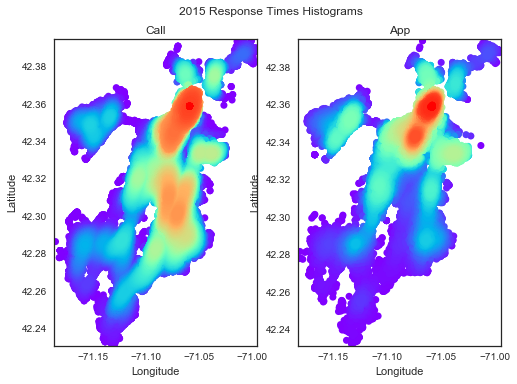

In [37]:
fig = plt.figure()
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(1,2,1)

data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'OPEN_DT')
plot_geo_intensity(data, ax1, 'Call')

data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Citizens Connect App', 'OPEN_DT')

ax2 = fig.add_subplot(1,2,2)
plot_geo_intensity(data, ax2, 'App')

plt.suptitle('2015 Response Times Histograms')

plt.show()

### By Department

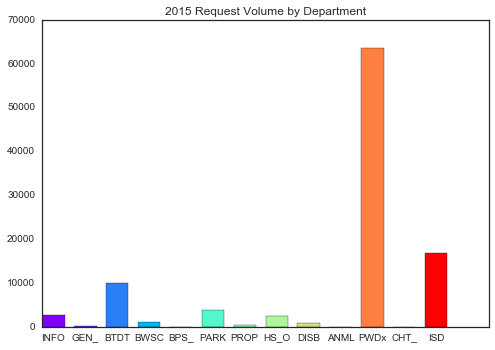

In [6]:
begin = pd.to_datetime('January 01, 2015 12:00AM') 
end = pd.to_datetime('January 01, 2016 12:00AM')
    
# Filter for requests opened between begin and end dates
in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]
    
# Filter for requests with specific source
in_range = in_range[in_range['Source'] == 'Constituent Call']

counter = Counter(in_range['Department'])
dept_keys = counter.keys()
dept_counts = counter.values()

indexes = np.arange(len(dept_keys))
width = 0.7

values = np.linspace(0, 1, len(dept_keys))
cm = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
colorVal = scalarMap.to_rgba(values)

plt.bar(indexes, dept_counts, width, color=colorVal)
plt.xticks(indexes + width * 0.5, dept_keys)
plt.ylim(0, )
plt.title('2015 Request Volume by Department')

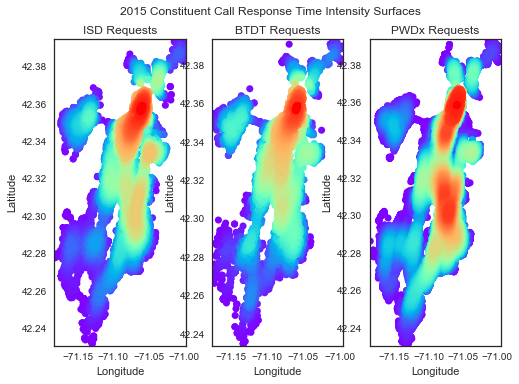

In [38]:
isd_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Constituent Call', 'OPEN_DT', dept='ISD')
btdt_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='BTDT')
pwdx_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='PWDx')


fig = plt.figure()
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(1,3,1)
plot_geo_intensity(isd_data, ax1, 'ISD Requests')

ax2 = fig.add_subplot(1,3,2)
plot_geo_intensity(btdt_data, ax2, 'BTDT Requests')

ax3 = fig.add_subplot(1,3,3)
plot_geo_intensity(pwdx_data, ax3, 'PWDx Requests')

plt.suptitle('2015 Constituent Call Response Time Intensity Surfaces')
plt.show()

## Response Time Visualizations

### By Source

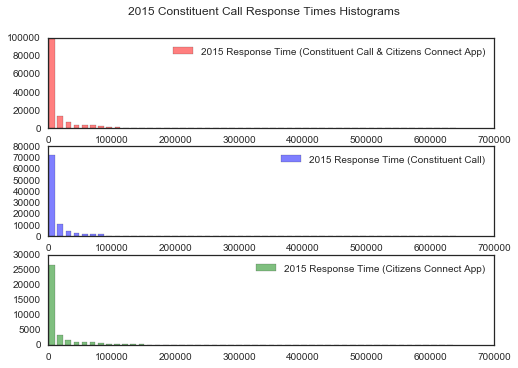

In [22]:
call_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Constituent Call', 'OPEN_DT')[:,0]
app_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Citizens Connect App', 'OPEN_DT')[:,0]

data = np.hstack((call_data, app_data))

fig = plt.figure()
ax1 = fig.add_subplot(3,1,1)

hist, bins = np.histogram(data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

ax1.bar(center, hist, align='center', width=width, color='r', alpha=0.5, label='2015 Response Time (Constituent Call & Citizens Connect App)')
ax1.legend(loc='best')

ax2 = fig.add_subplot(3,1,2)
hist, bins = np.histogram(call_data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

ax2.bar(center, hist, align='center', width=width, color='b', alpha=0.5, label='2015 Response Time (Constituent Call)')
ax2.legend(loc='best')

ax3 = fig.add_subplot(3,1,3)
hist, bins = np.histogram(app_data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

ax3.bar(center, hist, align='center', width=width, color='g', alpha=0.5, label='2015 Response Time (Citizens Connect App)')
ax3.legend(loc='best')

plt.suptitle('2015 Constituent Call Response Times Histograms')

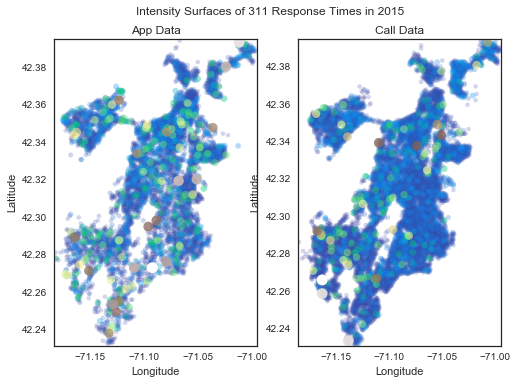

In [52]:
call_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Constituent Call', 'OPEN_DT')
app_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Citizens Connect App', 'OPEN_DT')
    

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plot_time_intensity(app_data, ax1, 'App Data')
ax2 = fig.add_subplot(1,2,2)
plot_time_intensity(call_data, ax2, 'Call Data')
plt.suptitle('Intensity Surfaces of 311 Response Times in 2015')
plt.show()

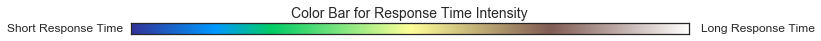

In [84]:
plot_color_gradients()

### By Department

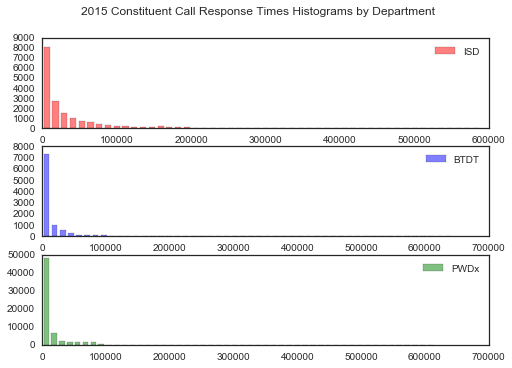

In [16]:
isd_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Constituent Call', 'OPEN_DT', dept='ISD')[:,0]
btdt_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='BTDT')[:,0]
pwdx_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='PWDx')[:,0]

hist, bins = np.histogram(isd_data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.subplot(3, 1, 1)
plt.bar(center, hist, align='center', width=width, color='r', alpha=0.5, label='ISD')
plt.legend(loc='best')

hist, bins = np.histogram(btdt_data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.subplot(3, 1, 2)
plt.bar(center, hist, align='center', width=width, color='b', alpha=0.5, label='BTDT')
plt.legend(loc='best')

hist, bins = np.histogram(pwdx_data, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.subplot(3, 1, 3)
plt.bar(center, hist, align='center', width=width, color='g', alpha=0.5, label='PWDx')
plt.legend(loc='best')
plt.suptitle('2015 Constituent Call Response Times Histograms by Department')

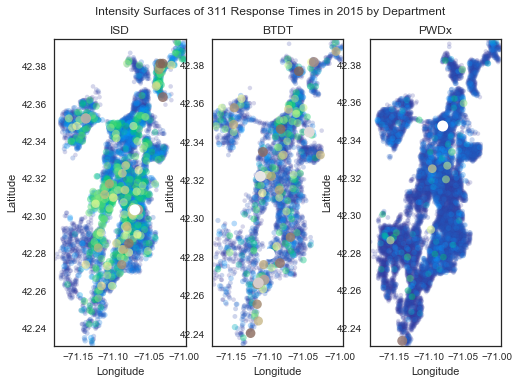

In [53]:
isd_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                     'Constituent Call', 'OPEN_DT', dept='ISD')
btdt_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='BTDT')
pwdx_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                      'Constituent Call', 'OPEN_DT', dept='PWDx')

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
plot_time_intensity(isd_data, ax1, 'ISD')

ax2 = fig.add_subplot(1,3,2)
plot_time_intensity(btdt_data, ax2, 'BTDT')

ax2 = fig.add_subplot(1,3,3)
plot_time_intensity(pwdx_data, ax2, 'PWDx')

plt.suptitle('Intensity Surfaces of 311 Response Times in 2015 by Department')
plt.show()

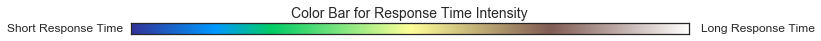

In [85]:
plot_color_gradients()